In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
import seaborn as sns
import matplotlib.colors as mcolors

from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr, zscore

pd.set_option("display.width", 80)
pd.set_option("display.max_colwidth", None)

In [2]:
# 1. load all data files and pair them as a corpus
data_files = os.listdir("data")
reward_df_files = sorted(
    [f for f in data_files if "scoredreward_humanassistant_includeprompt" in f]
)
nll_df_files = sorted(
    [f for f in data_files if "scorednll" in f and "includeprompt" not in f]
)
correction_files = sorted([f for f in data_files if "scoredcorrectionnll" in f])

triplet_files = [
    (r, n, c) for r, n, c in zip(reward_df_files, nll_df_files, correction_files)
]
assert len(reward_df_files) == len(nll_df_files) == len(correction_files)

for r, n, c in triplet_files:
    print()
    print(r)
    print(n)
    print(c)


ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredcorrectionnll_ancestral_1.0_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scorednll.csv
ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredcorrectionnll_ancestral_1.5_humanassistant_includeprompt_conditioned.csv

ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_

In [3]:
# 2. set parameters
num_corpuses = 1000
num_samples_per_corpus = 2000
metropolis_steps = 1000

colours = list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.BASE_COLORS.keys())
names = [
    "k50_t1.0",
    "k50_t1.5",
    "k50_t2.0",
    "eta_n00009_t1.0",
    "eta_n00009_t1.5",
    "eta_n00009_t2.0",
    "top_k30_t1.0",
    "top_k30_t1.5",
    "top_k30_t2.0",
    "p090_t1.0",
    "p090_t1.5",
    "p090_t2.0",
    "p095_t1.0",
    "p095_t1.5",
    "p095_t2.0",
    "typical_p090_t1.0",
    "typical_p090_t1.5",
    "typical_p090_t2.0",
]
assert len(colours) >= len(triplet_files)
assert len(names) == len(triplet_files)



Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.0_humanassistant_scorednll.csv:
Length: 1943
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2531285651285652, pvalue=4.388290882666575e-16)
Pearson: PearsonRResult(statistic=0.2627456770741331, pvalue=2.983559526263806e-17)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t1.5_humanassistant_scorednll.csv:
Length: 1986
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.1238859158859159, pvalue=8.570614222039302e-05)
Pearson: PearsonRResult(statistic=0.13668760938961083, pvalue=1.4417266017844942e-05)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_ancestral_t2.0_humanassistant_scorednll.csv:
Length: 2000
+----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2911342111342111, pvalue=5.4925085006685305e-21)
Pearson: PearsonRResult(statistic=0.29532883462591913, pvalue=1.4139320736099528e-21)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.0_humanassistant_scorednll.csv:
Length: 1939
+----+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.1713998793998794, pvalue=4.931347534635002e-08)
Pearson: PearsonRResult(statistic=0.1978918268696862, pvalue=2.744027090949211e-10)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t1.5_humanassistant_scorednll.csv:
Length: 1981
+----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.24099748899748902, pvalue=1.1130592934204915e-14)
Pearson: PearsonRResult(statistic=0.2507171702458911, pvalue=8.462007115225625e-16)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_eta_n00009_t2.0_humanassistant_scorednll.csv:
Length: 1995
+----+------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.30499103299103303, pvalue=5.691313316015317e-23)
Pearson: PearsonRResult(statistic=0.3185211272679706, pvalue=5.147165376069744e-25)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t1.0_humanassistant_scorednll.csv:
Length: 1941
+----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.3163636483636484, pvalue=1.1080813354245938e-24)
Pearson: PearsonRResult(statistic=0.3393882974064122, pvalue=2.2275288120125595e-28)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t1.5_humanassistant_scorednll.csv:
Length: 1986
+----+------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.18507157707157706, pvalue=3.7205028040457443e-09)
Pearson: PearsonRResult(statistic=0.189875696581214, pvalue=1.4303667533427354e-09)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_k30_t2.0_humanassistant_scorednll.csv:
Length: 1997
+----+------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2199004599004599, pvalue=2.0446115768701615e-12)
Pearson: PearsonRResult(statistic=0.23144605941955682, pvalue=1.256720661028164e-13)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.0_humanassistant_scorednll.csv:
Length: 1905
+----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.30990850590850594, pvalue=1.0585403628245353e-23)
Pearson: PearsonRResult(statistic=0.336625429602382, pvalue=6.431104487737252e-28)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t1.5_humanassistant_scorednll.csv:
Length: 1986
+----+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2537824217824218, pvalue=3.668155087930269e-16)
Pearson: PearsonRResult(statistic=0.26653145703201137, pvalue=1.0040420754972601e-17)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p090_t2.0_humanassistant_scorednll.csv:
Length: 1998
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.23178777978777984, pvalue=1.154437657979896e-13)
Pearson: PearsonRResult(statistic=0.23144642699616985, pvalue=1.2566059991694732e-13)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.0_humanassistant_scorednll.csv:
Length: 1921
+----+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.3713048753048753, pvalue=4.801123150179332e-34)
Pearson: PearsonRResult(statistic=0.3775409636885787, pvalue=3.1416749979807126e-35)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t1.5_humanassistant_scorednll.csv:
Length: 1982
+----+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2596251916251916, pvalue=7.225990386430198e-17)
Pearson: PearsonRResult(statistic=0.25545764234162427, pvalue=2.3119603968786397e-16)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_top_p095_t2.0_humanassistant_scorednll.csv:
Length: 1997
+----+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.32351121551121553, pvalue=8.528302847249837e-26)
Pearson: PearsonRResult(statistic=0.352490533857164, pvalue=1.2586563986093975e-30)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t1.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t1.0_humanassistant_scorednll.csv:
Length: 1907
+----+------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+--------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.3096591336591337, pvalue=1.1536847649806263e-23)
Pearson: PearsonRResult(statistic=0.32912914192439147, pvalue=1.0820390061551223e-26)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t1.5_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t1.5_humanassistant_scorednll.csv:
Length: 1975
+----+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.2905562185562186, pvalue=6.610115846036249e-21)
Pearson: PearsonRResult(statistic=0.2935957593793533, pvalue=2.4837998933249917e-21)


Analyzing ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t2.0_humanassistant_scoredreward_humanassistant_includeprompt.csv and ethz-spylab-rlhf-7b-harmless_l256_promptseed42_numprompt1000_numgenerations2_typical_p090_t2.0_humanassistant_scorednll.csv:
Length: 1993
+----+------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_238817/1118697791.py:43: RuntimeWarning: overflow encountered in exp
  np.exp(


===== Corpus level statistics =====
Spearman: SignificanceResult(statistic=0.24190113790113793, pvalue=8.800818393134662e-15)
Pearson: PearsonRResult(statistic=0.2592637637326425, pvalue=7.999470403749287e-17)
===== Corrected corpus level statistics =====
Removed 512 samples due to infinitiy.
Spearman: SignificanceResult(statistic=-0.714977034977035, pvalue=2.676102142923387e-157)
Pearson: PearsonRResult(statistic=-0.7301797431147239, pvalue=2.8325541391463184e-167)
===== Metropolis corpus level statistics =====


/tmp/ipykernel_238817/1118697791.py:206: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt", as_index=False).apply(


Algorithm acceptance rate: 1.0
Acceptance rate: 1.0
Spearman: SignificanceResult(statistic=0.3049692058841135, pvalue=5.733556137277815e-23)
Pearson: PearsonRResult(statistic=0.3125753161674188, pvalue=4.194859001162452e-24)
===== Total corpus level statistics =====
Spearman: SignificanceResult(statistic=0.28778069781737786, pvalue=0.0)
Pearson: PearsonRResult(statistic=0.19281254032025869, pvalue=7.552571430760226e-294)
===== Total corpus mean statistics =====
Spearman: SignificanceResult(statistic=-0.9428976538793139, pvalue=0.0)
Pearson: PearsonRResult(statistic=-0.9486523874108239, pvalue=0.0)
===== Total metropolis corpus mean statistics =====
Spearman: SignificanceResult(statistic=-0.8946605081248186, pvalue=0.0)
Pearson: PearsonRResult(statistic=-0.898429969411232, pvalue=0.0)


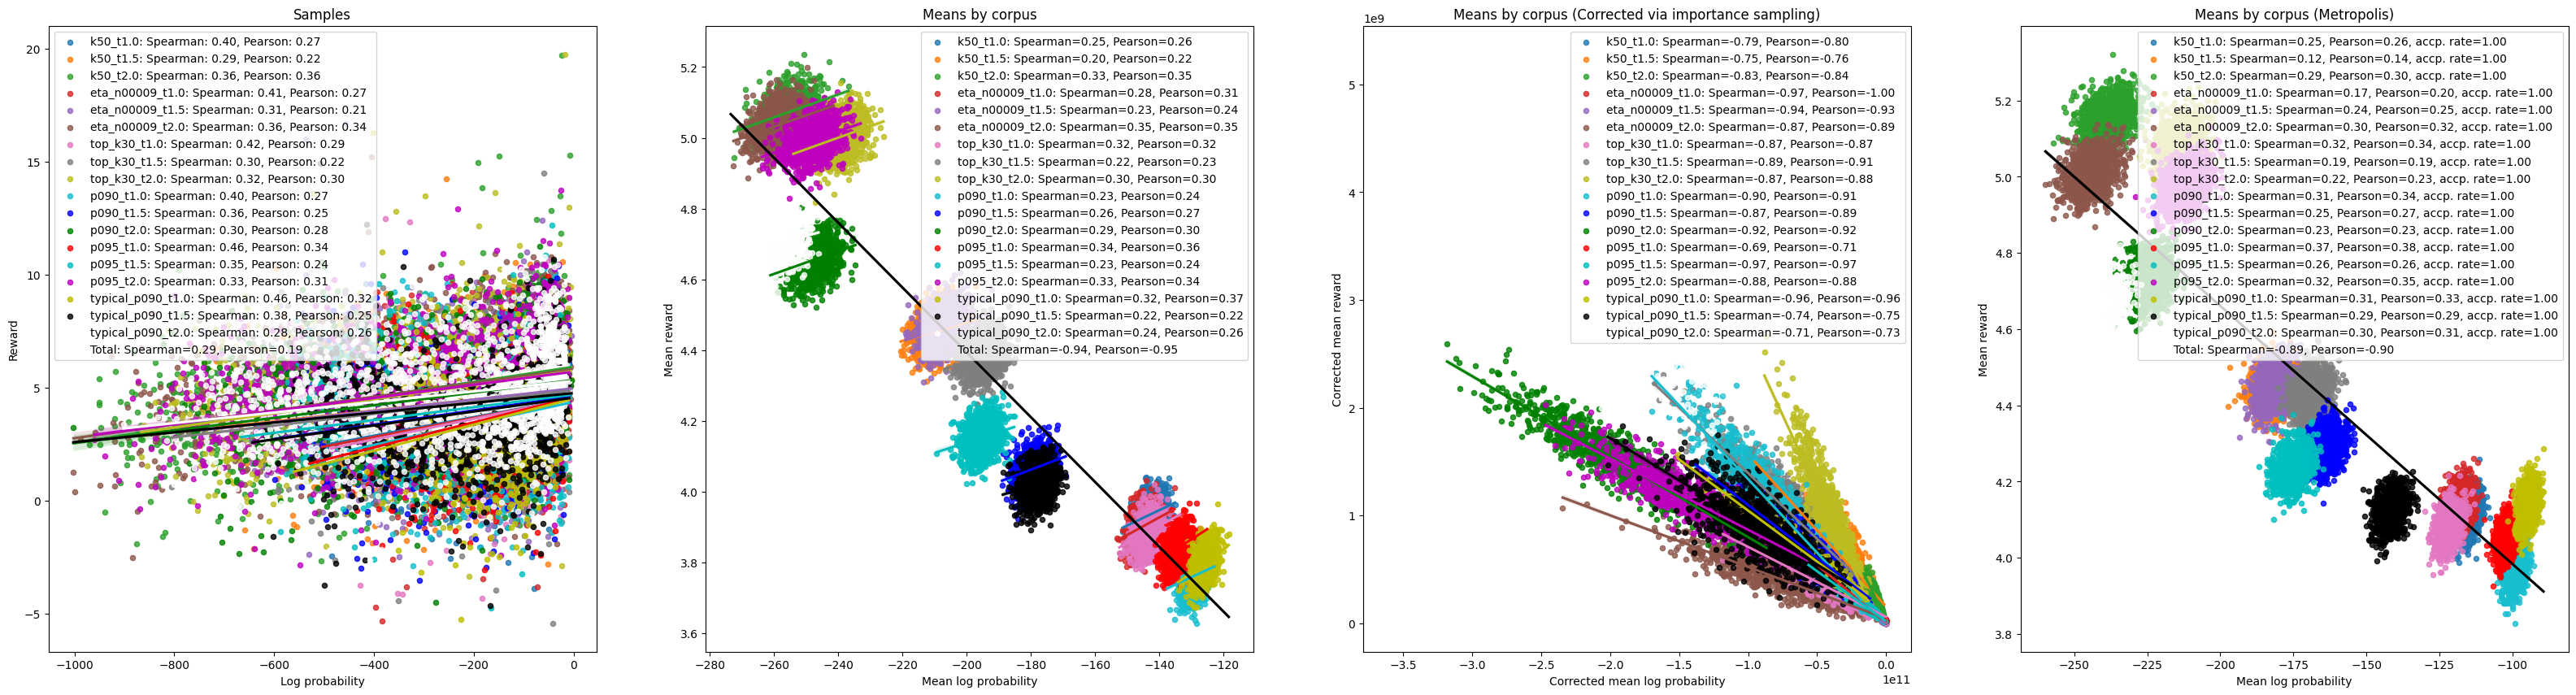

In [58]:
# 3. analysis on each corpus
# 3.0 a single output figure
fig, axs = plt.subplots(1, 4, figsize=(40, 10))
total_mean_corpuses = None
total_corpus = None
total_mean_corrected_corpuses = None
total_mean_metropolis_corpuses = None
acceptance_rates = dict()
for idx, (reward_df_file, nll_df_file, correction_df_file) in enumerate(triplet_files):
    print(f"\n\nAnalyzing {reward_df_file} and {nll_df_file}:")
    # 3.1 load and merge
    reward_df = pd.read_csv(f"data/{reward_df_file}")
    nll_df = pd.read_csv(f"data/{nll_df_file}")
    correction_df = pd.read_csv(f"data/{correction_df_file}")
    df = reward_df.merge(nll_df, on=["prompt", "generated_text"]).merge(
        correction_df, on=["prompt", "generated_text"], how="inner"
    )

    # 3.1.1 get log probability
    df["log_probability"] = -df["negative_log_probability"]

    # 3.1.2 filter duplicates, empty strings, invalid probabilities
    df = df[
        df.apply(lambda row: len(row["generated_text"]) > 0, axis=1)
    ].drop_duplicates()
    df = df[df["negative_log_probability"].isin([-np.inf, np.inf]) == False]
    df = df[df["negative_log_probability"].isnull() == False]
    df = df[df["score"].isin([-np.inf, np.inf]) == False]
    df = df[df["score"].isnull() == False]

    assert len(df) > 0
    print(f"Length: {len(df)}")
    print(tabulate(df.head(), headers="keys", tablefmt="psql"))
    print(
        tabulate(
            df[["score", "log_probability"]].describe(), headers="keys", tablefmt="psql"
        )
    )

    # 3.1.3 compute correction ratio
    df["correction_ratio"] = df.apply(
        lambda row: (
            np.exp(
                -row["original_negative_log_probability"]
                + row["samplingbiased_negative_log_probability"]
            )
        ),
        axis=1,
    )
    df = df[
        df["correction_ratio"].apply(
            lambda x: False if (np.isinf(x) or np.isnan(x)) else True
        )
    ]
    # df = df[(np.abs(zscore(df[["correction_ratio"]])) < 1.5).all(axis=1)]
    df["corrected_score"] = df.apply(
        lambda row: row["score"] * row["correction_ratio"], axis=1
    )
    df["corrected_log_probability"] = df.apply(
        lambda row: row["log_probability"] * row["correction_ratio"],
        axis=1,
    )

    # 3.2 Sample level
    print("===== Sample level statistics =====")
    # 3.2.1 Scatter
    spearman = spearmanr(df["score"], df["log_probability"])
    pearson = pearsonr(df["score"], df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    df.plot.scatter(
        y="score",
        x="log_probability",
        title="Samples",
        ax=axs[0],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman: {spearman[0]:.2f}, Pearson: {pearson[0]:.2f}",
    )
    # 3.2.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=df,
        ax=axs[0],
        scatter=False,
        color=colours[idx],
    )
    if total_corpus is None:
        total_corpus = df
    else:
        total_corpus = pd.concat([total_corpus, df])

    # 3.3 Corpus level
    print("===== Corpus level statistics =====")
    # 3.3.1 Sample corpuses
    corpuses = {
        corpus_seed: df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    pearson = pearsonr(mean_corpuses_df["score"], mean_corpuses_df["log_probability"])
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus",
        ax=axs[1],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corpuses is None:
        total_mean_corpuses = mean_corpuses_df
    else:
        total_mean_corpuses = pd.concat([total_mean_corpuses, mean_corpuses_df])

    # 3.3.2 best fit line
    sns.regplot(
        y="score",
        x="log_probability",
        data=mean_corpuses_df,
        ax=axs[1],
        scatter=False,
        color=colours[idx],
    )

    # 3.4 corrected corpus level
    print("===== Corrected corpus level statistics =====")
    # 3.4.1 Sample corpuses
    importance_df = df[
        (
            df["samplingbiased_negative_log_probability"]
            - df["original_negative_log_probability"]
        )
        < 25
    ]
    diff = len(df) - len(importance_df)
    print(f"Removed {diff} samples due to infinitiy.")
    corpuses = {
        corpus_seed: importance_df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["corrected_score", "corrected_log_probability"]].mean(
            axis=0
        )
        for corpus_seed, corpus in corpuses.items()
    }).T
    spearman = spearmanr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["corrected_score"],
        mean_corpuses_df["corrected_log_probability"],
    )
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="corrected_score",
        x="corrected_log_probability",
        title="Means by corpus (Corrected via importance sampling)",
        ax=axs[2],
        c=colours[idx],
        alpha=0.8,
        label=f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    )
    if total_mean_corrected_corpuses is None:
        total_mean_corrected_corpuses = mean_corpuses_df
    else:
        total_mean_corrected_corpuses = pd.concat(
            [total_mean_corrected_corpuses, mean_corpuses_df]
        )

    # 3.4.2 best fit line
    sns.regplot(
        y="corrected_score",
        x="corrected_log_probability",
        data=mean_corpuses_df,
        ax=axs[2],
        scatter=False,
        color=colours[idx],
    )

    # 3.5 metropolis corpus level
    print("===== Metropolis corpus level statistics =====")
    # 3.5.0 metropolis
    metropolis_df = None
    # stratified sampling
    samples = pd.concat([
        df.groupby("prompt", as_index=False).apply(
            lambda group: group.sample(
                n=np.ceil((metropolis_steps) / len(df["prompt"].unique()))
                .astype(int)
                .item(),
                replace=True,
                random_state=0,
                weights=np.exp(-group["original_negative_log_probability"]) + 1e-25,
            ),
        ),
        df.sample(
            n=1,
            random_state=0,
            replace=True,
            weights=np.exp(-df["original_negative_log_probability"]),
        ),
    ])
    # samples = df.sample(
    #     n=metropolis_steps + 1,
    #     replace=True,
    #     random_state=0,
    #     weights=np.exp(-df["original_negative_log_probability"]),
    # )

    acceptance_thresholds = np.random.uniform(0.0, 1.0, size=metropolis_steps)
    acceptances = dict()
    acceptance_count = 0
    prev = samples.iloc[0]
    for step in range(1, metropolis_steps + 1):
        sample = samples.iloc[step]
        acceptance = (
            min(
                1.0,
                (
                    np.exp(
                        np.array(
                            -sample["original_negative_log_probability"]
                            - prev["samplingbiased_negative_log_probability"]
                            + prev["original_negative_log_probability"]
                            + sample["samplingbiased_negative_log_probability"]
                        ).astype(np.float128)
                    ).item()
                ),
            )
            > acceptance_thresholds[step - 1],
        )
        if acceptance:
            acceptance_count += 1
            prev = sample
            acceptances[(sample["prompt"], sample["generated_text"])] = True
            to_add = df[
                (df["prompt"] == sample["prompt"])
                & (df["generated_text"] == sample["generated_text"])
            ]
        else:
            acceptances[(prev["prompt"], prev["generated_text"])] = True
            to_add = df[
                (df["prompt"] == prev["prompt"])
                & (df["generated_text"] == prev["generated_text"])
            ]
        if metropolis_df is None:
            metropolis_df = to_add
        else:
            metropolis_df = pd.concat([metropolis_df, to_add])
    acceptance_rate = np.mean(list(acceptances.values()))
    algorithm_acceptance_rate = acceptance_count / metropolis_steps
    print(f"Algorithm acceptance rate: {algorithm_acceptance_rate}")
    print(f"Acceptance rate: {acceptance_rate}")
    df["acceptance"] = df.apply(
        lambda row: acceptances.get((row["prompt"], row["generated_text"]), False),
        axis=1,
    )

    # 3.5.1 Sample corpuses
    corpuses = {
        corpus_seed: metropolis_df.sample(
            num_samples_per_corpus, random_state=corpus_seed, replace=True
        )
        for corpus_seed in range(num_corpuses)
    }
    mean_corpuses_df = pd.DataFrame.from_dict({
        corpus_seed: corpus[["score", "log_probability"]].mean(axis=0)
        for corpus_seed, corpus in corpuses.items()
    }).T

    spearman = spearmanr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    pearson = pearsonr(
        mean_corpuses_df["score"],
        mean_corpuses_df["log_probability"],
    )
    print(f"Spearman: {spearman}")
    print(f"Pearson: {pearson}")
    mean_corpuses_df.plot.scatter(
        y="score",
        x="log_probability",
        title="Means by corpus (Metropolis)",
        ax=axs[3],
        c=colours[idx],
        alpha=0.8,
        label=(
            f"{names[idx]}: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}, accp."
            f" rate={algorithm_acceptance_rate:.2f}"
        ),
    )
    if total_mean_metropolis_corpuses is None:
        total_mean_metropolis_corpuses = mean_corpuses_df
    else:
        total_mean_metropolis_corpuses = pd.concat(
            [total_mean_metropolis_corpuses, mean_corpuses_df]
        )

# 4. Total corpus level statistics
# 4.1 sample
print("===== Total corpus level statistics =====")
spearman = spearmanr(total_corpus["score"], total_corpus["log_probability"])
pearson = pearsonr(total_corpus["score"], total_corpus["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_corpus.plot.scatter(
    y="score",
    x="log_probability",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[0],
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_corpus,
    scatter=False,
    color="black",
    ax=axs[0],
)
axs[0].set_ylabel("Reward")
axs[0].set_xlabel("Log probability")

# 4.2 corpus
print("===== Total corpus mean statistics =====")
spearman = spearmanr(
    total_mean_corpuses["score"], total_mean_corpuses["log_probability"]
)
pearson = pearsonr(total_mean_corpuses["score"], total_mean_corpuses["log_probability"])
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[1],
    ylabel="Mean score",
    xlabel="Mean log probability",
)

sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_corpuses,
    scatter=False,
    color="black",
    ax=axs[1],
)
axs[1].set_ylabel("Mean reward")
axs[1].set_xlabel("Mean log probability")

# 4.3 corrected corpus
axs[2].set_ylabel("Corrected mean reward")
axs[2].set_xlabel("Corrected mean log probability")

# 4.4 corrected metropolis corpus
print("===== Total metropolis corpus mean statistics =====")
spearman = spearmanr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
pearson = pearsonr(
    total_mean_metropolis_corpuses["score"],
    total_mean_metropolis_corpuses["log_probability"],
)
print(f"Spearman: {spearman}")
print(f"Pearson: {pearson}")
total_mean_metropolis_corpuses.plot.scatter(
    y="score",
    x="log_probability",
    title="Means by corpus (Metropolis)",
    alpha=0.0,
    label=f"Total: Spearman={spearman[0]:.2f}, Pearson={pearson[0]:.2f}",
    ax=axs[3],
    ylabel="Mean reward",
    xlabel="Mean log probability",
)
sns.regplot(
    y="score",
    x="log_probability",
    data=total_mean_metropolis_corpuses,
    scatter=False,
    color="black",
    ax=axs[3],
)
axs[3].set_ylabel("Mean reward")
axs[3].set_xlabel("Mean log probability")

plt.legend()
plt.show()
plt.close()

0

In [53]:
t = (
    df.groupby("prompt")
    .apply(
        # lambda group: group.sample(
        #     n=np.ceil((metropolis_steps) / len(df["prompt"].unique())).astype(int).item(),
        #     replace=True,
        #     random_state=0,
        #     weights=np.exp(-group["original_negative_log_probability"] + 1e-3),
        # )
        lambda group: np.exp(-group["original_negative_log_probability"])
        .astype(np.float128)
        .sum()
        + 1e-6
    )
    .to_frame()
)
t[t[0] == 0]

/tmp/ipykernel_238817/1718397506.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("prompt")


,0
prompt,


In [50]:
df[df["prompt"] == "Human: How can I defrost cooked chicken?\n\nAssistant:"]

,prompt,generated_text,score,score_text,negative_log_probability,negative_log_probability_text,original_negative_log_probability,samplingbiased_negative_log_probability,nll_correction_texts,log_probability,correction_ratio,corrected_score,corrected_log_probability
916,Human: How can I defrost cooked chicken?\n\nAssistant:,"This may involve microwave energy. Alternatively for food safety, chicken thaws from room temperature in a sealed cupboard for about two days, or at fridge temperature on a tray at a corner for about 6 hours to reach maximum use-freezing temperatur... It should be frozen first in general, though. You want the thickness with the greatest insulation from coldness around your thawing food product of a meal package and cupboard. \n(For safety after opening, food safety and sanitation and shelf-Life - the “luxuryn factor” being the highest-grade meats) - For foodservice for food manufacturing, they prefer a frozen state (including raw chicken as the pesticides from chicken is kept to minimum in refrigeration - some meat comes from warm ambient temperate climates in transport) as food transport is usually to temperature ambient, but you can start with defrosting with frozen pack/plate/cup. Chicken, and meat tends to dwarves microbes in collagen cells (connective tissue holding cells) of chook legs than",4.240694,"Human: How can I defrost cooked chicken?\n\n Assistant: This may involve microwave energy. Alternatively for food safety, chicken thaws from room temperature in a sealed cupboard for about two days, or at fridge temperature on a tray at a corner for about 6 hours to reach maximum use-freezing temperatur... It should be frozen first in general, though. You want the thickness with the greatest insulation from coldness around your thawing food product of a meal package and cupboard. \n(For safety after opening, food safety and sanitation and shelf-Life - the “luxuryn factor” being the highest-grade meats) - For foodservice for food manufacturing, they prefer a frozen state (including raw chicken as the pesticides from chicken is kept to minimum in refrigeration - some meat comes from warm ambient temperate climates in transport) as food transport is usually to temperature ambient, but you can start with defrosting with frozen pack/plate/cup. Chicken, and meat tends to dwarves microbes in collagen cells (connective tissue holding cells) of chook legs than",950.515381,"This may involve microwave energy. Alternatively for food safety, chicken thaws from room temperature in a sealed cupboard for about two days, or at fridge temperature on a tray at a corner for about 6 hours to reach maximum use-freezing temperatur... It should be frozen first in general, though. You want the thickness with the greatest insulation from coldness around your thawing food product of a meal package and cupboard. \n(For safety after opening, food safety and sanitation and shelf-Life - the “luxuryn factor” being the highest-grade meats) - For foodservice for food manufacturing, they prefer a frozen state (including raw chicken as the pesticides from chicken is kept to minimum in refrigeration - some meat comes from warm ambient temperate climates in transport) as food transport is usually to temperature ambient, but you can start with defrosting with frozen pack/plate/cup. Chicken, and meat tends to dwarves microbes in collagen cells (connective tissue holding cells) of chook legs than",880.811951,850.638733,"Human: How can I defrost cooked chicken?\n\n Assistant: This may involve microwave energy. Alternatively for food safety, chicken thaws from room temperature in a sealed cupboard for about two days, or at fridge temperature on a tray at a corner for about 6 hours to reach maximum use-freezing temperatur... It should be frozen first in general, though. You want the thickness with the greatest insulation from coldness around your thawing food product of a meal package and cupboard. \n(For safety after opening, food safety and sanit